In [1]:
import glob
import os
import re
import tensorflow as tf
import numpy as np

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '\t\t\t“There must be some way out of here,” said the joker to the thief', '“There’s too much confusion, I can’t get no relief']


In [2]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 10: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

			“There must be some way out of here,” said the joker to the thief
“There’s too much confusion, I can’t get no relief
Businessmen, they drink my wine, plowmen dig my earth
None of them along the line know what any of it is worth”
“No reason to get excited,” the thief, he kindly spoke
“There are many here among us who feel that life is but a joke
But you and I, we’ve been through that, and this is not our fate
So let us not talk falsely now, the hour is getting late”


In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       # 소문자로 바꾸고 양쪽 공백을 삭제
  
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                  # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'      # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))   # 이 문장이 어떻게 필터링되는지 확인해 보세요.

<start> this is sample sentence . <end>


In [4]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if len(sentence.split()) >=12 : continue
                
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> there s too much confusion , i can t get no relief <end>',
 '<start> businessmen , they drink my wine , plowmen dig my earth <end>',
 '<start> no reason to get excited , the thief , he kindly spoke <end>',
 '<start> all along the watchtower , princes kept the view <end>',
 '<start> while all the women came and went , barefoot servants , too <end>',
 '<start> outside in the distance a wildcat did growl <end>',
 '<start> two riders were approaching , the wind began to howl <end>',
 '<start> once upon a time you dressed so fine <end>',
 '<start> you threw the bums a dime in your prime , didn t you ? <end>',
 '<start> people d call , say , beware doll , you re bound to fall <end>']

In [5]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=10000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   62   16 ...    0    0    0]
 [   2    1    4 ...    0    0    0]
 [   2   37  593 ...    0    0    0]
 ...
 [   2    9  156 ...    0    0    0]
 [   2    8    9 ...    0    0    0]
 [   2    6 3231 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7ff74052e650>


In [6]:
print(tensor[:3, :10])

[[   2   62   16  101  186 2636    4    5   33   15]
 [   2    1    4   43  489   13  987    4    1 1037]
 [   2   37  593   10   45 2495    4    6 2240    4]]


In [7]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [8]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])

[   2   62   16  101  186 2636    4    5   33   15   45   37 5631    3
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
[  62   16  101  186 2636    4    5   33   15   45   37 5631    3    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [9]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 400
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1    # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((400, 29), (400, 29)), types: (tf.int32, tf.int32)>

In [10]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=16)

In [11]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)

Source Train: (121848, 29)
Target Train: (121848, 29)


In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [13]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(400, 29, 10001), dtype=float32, numpy=
array([[[-7.96146996e-05,  2.00651921e-05,  1.70701111e-04, ...,
         -2.51502293e-04,  1.23648701e-04, -1.51112385e-04],
        [-2.10195081e-04, -2.97296665e-05,  2.97125225e-04, ...,
         -1.97419868e-04, -2.06254568e-04, -1.77606889e-05],
        [-4.20880504e-04,  4.57589158e-05,  6.35473843e-05, ...,
          1.64761776e-04, -5.24735486e-04, -8.92002427e-05],
        ...,
        [ 3.43861524e-03, -4.17868700e-03, -6.39388803e-03, ...,
          3.85112339e-03,  4.52968664e-03,  2.64681014e-03],
        [ 3.41598899e-03, -4.17157495e-03, -6.50213473e-03, ...,
          3.82945570e-03,  4.65208758e-03,  2.69865571e-03],
        [ 3.38810496e-03, -4.15686052e-03, -6.59125904e-03, ...,
          3.80435400e-03,  4.75549279e-03,  2.74244091e-03]],

       [[-7.96146996e-05,  2.00651921e-05,  1.70701111e-04, ...,
         -2.51502293e-04,  1.23648701e-04, -1.51112385e-04],
        [-2.56596036e-06,  1.19770353e-04,  9

In [ ]:
model.summary()

In [14]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

history = model.fit(enc_train, 
          dec_train, 
          epochs=10,
          batch_size=400,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/10
305/305 [==============================] - 124s 406ms/step - loss: 1.8339 - accuracy: 0.7445 - val_loss: 1.5507 - val_accuracy: 0.7621
Epoch 2/10
305/305 [==============================] - 126s 413ms/step - loss: 1.4841 - accuracy: 0.7678 - val_loss: 1.4447 - val_accuracy: 0.7713
Epoch 3/10
305/305 [==============================] - 127s 415ms/step - loss: 1.4025 - accuracy: 0.7738 - val_loss: 1.3870 - val_accuracy: 0.7753
Epoch 4/10
305/305 [==============================] - 136s 446ms/step - loss: 1.3458 - accuracy: 0.7775 - val_loss: 1.3471 - val_accuracy: 0.7782
Epoch 5/10
305/305 [==============================] - 128s 418ms/step - loss: 1.2990 - accuracy: 0.7806 - val_loss: 1.3145 - val_accuracy: 0.7810
Epoch 6/10
305/305 [==============================] - 132s 432ms/step - loss: 1.2561 - accuracy: 0.7838 - val_loss: 1.2879 - val_accuracy: 0.7832
Epoch 7/10
305/305 [==============================] - 132s 433ms/step - loss: 1.2157 - accuracy: 0.7869 - val_loss: 1.2629 -

In [15]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


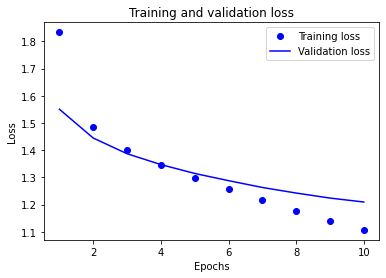

In [16]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

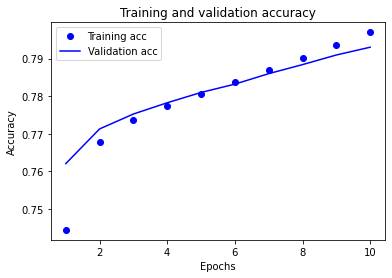

In [17]:
plt.clf()   # 그림을 초기화한다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, 
                                                                 tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [22]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m gonna be <end> '